<a href="https://colab.research.google.com/github/juliaviolet/Python_Options/blob/main/Merton_Options_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Merton's Jump Diffusion Model (1976):**

Merton's Jump Diffusion Model is an extension of the Black-Scholes option pricing model. The model was proposed by Robert C. Merton in 1976 to account for the fact that asset returns are not always normally distributed. Real-world asset returns often exhibit skewness and kurtosis not seen in a normal distribution, and Merton's model seeks to address this by introducing a jump component into the Black-Scholes model.

The model assumes that the price of the underlying asset follows a geometric Brownian motion with constant drift and volatility, which is the same assumption made by the Black-Scholes model. However, Merton's model adds a jump component to this, which is modeled as a Poisson process. The jump component allows the asset price to make large moves, or "jumps", at random points in time.

The stochastic differential equation (SDE) describing the asset price dynamics in Merton's model is given by:

$
dS_t = \mu S_t dt + \sigma S_t dW_t + S_t dJ_t
$

where $S_t$ is the asset price at time $t$, $\mu$ is the drift rate, $\sigma$ is the volatility, $W_t$ is a standard Wiener process, and $J_t$ is a compound Poisson process representing the jumps.

*Note: The model implementation below is experimental and its parameters have not been calibrated.

<ipython-input-8-a1b73a54e73b>:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


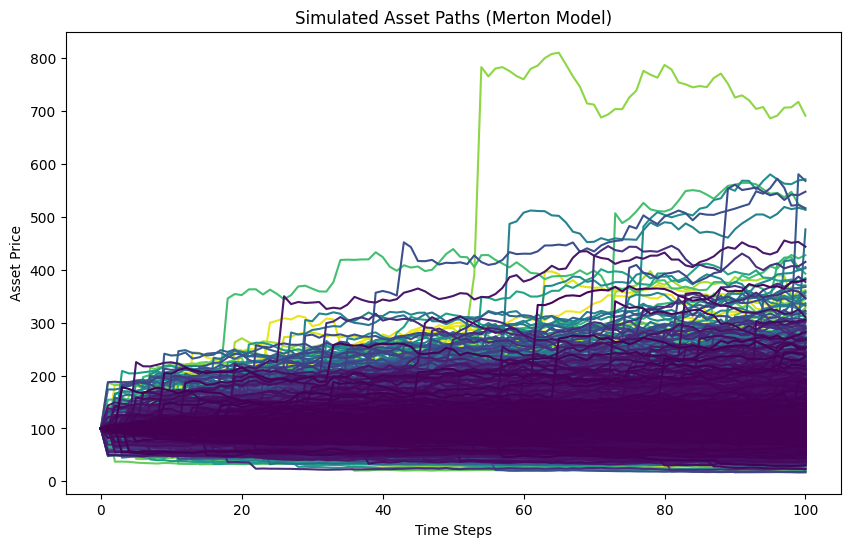

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def generate_asset_paths_Merton(S0, r, sigma, lambd, m, v, T, dt, n_sims):
    '''
    Generates asset paths for a given initial asset price S0, risk-free rate r,
    volatility sigma, jump intensity lambda, mean jump size m, jump size volatility v,
    total time T, time step dt, and number of simulations n_sims.
    '''
    # number of time steps
    N = round(T/dt)

    # array to store asset paths
    asset_paths = np.zeros((N + 1, n_sims))

    # initialize first row with initial asset price
    asset_paths[0] = S0

    # simulate asset paths
    for t in range(1, N + 1):
        brownian = np.random.standard_normal(n_sims)
        poi = np.random.poisson(lambd * dt, n_sims)
        norm_jump = np.random.normal(m, v, n_sims)
        asset_paths[t] = asset_paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * brownian + norm_jump * poi)

    return asset_paths

# Define your parameters
S0 = 100  # initial asset price
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
lambd = 1.0 # jump intensity
m = 0.0 # mean jump size
v = 0.3 # jump size volatility
T = 1.0  # total time
dt = 0.01  # time step
n_sims = 10000  # number of simulations

# generate asset paths
asset_paths = generate_asset_paths_Merton(S0, r, sigma, lambd, m, v, T, dt, n_sims)

# convert to DataFrame for easier viewing
df_asset_paths = pd.DataFrame(asset_paths)

# Plotting
cmap = cm.get_cmap('viridis')
plt.figure(figsize=(10, 6))
colors = cmap(np.linspace(1, 0, n_sims))

for i in range(n_sims):
    plt.plot(df_asset_paths.index, df_asset_paths[i], color=colors[i])

plt.title('Simulated Asset Paths (Merton Model)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

The **Carr-Madan Fast Fourier Transform (FFT) method**, introduced by Peter Carr and Dilip Madan, is an efficient numerical method for valuing options based on the Black-Scholes-Merton (BSM) model. This method computes prices for a large number of strike prices by applying the FFT to a modification of the characteristic function implied by the BSM model.

The key insight of the Carr-Madan method is the ability to express the price of a European call option as an inverse Fourier transform of a modified version of the characteristic function of the log asset price. This modification, involving the introduction of a damping factor, ensures quick decay of the integrand in the inverse Fourier transform, making the numerical integration more stable and accurate.

The Carr-Madan FFT method derives from the risk-neutral valuation formula, which states that the price of a derivative is the expected value of its future payoff under the risk-neutral measure, discounted at the risk-free rate. The method proves particularly useful in situations where a large number of option prices need to be computed due to its speed and accuracy.

Here are the steps of the Carr-Madan FFT method:

**Step 1: Setup**

Set up the parameters for the FFT. These include the number of points for the FFT (usually a power of 2, such as 256 or 512), the size of the step in the log-strike space (denoted by \(\Delta\)), and the maximum log-strike.

**Step 2: Define the characteristic function**

The characteristic function of the log asset price under the risk-neutral measure in the BSM model is given by:

$
\phi(u; T) = \exp\left(iu\left(\ln(S_0) + \left(r-\frac{\sigma^2}{2}\right)T\right) - \frac{\sigma^2u^2T}{2}\right)
$

where $T$ is the time to maturity, $S_0$ is the initial asset price, $r$ is the risk-free rate, $\sigma$ is the volatility, and $i$ is the imaginary unit.

**Step 3: Define the modified characteristic function**

Introduce a damping factor into the characteristic function, resulting in the modified characteristic function. The damping factor is introduced to ensure quick decay of the integrand in the inverse Fourier transform, making the numerical integration more stable and accurate.

$
\phi_{\text{mod}}(u; T) = e^{iub}\phi(u-i; T)
$

where \(b\) is the damping factor.

**Step 4: Define the Fourier transform**

Define the Fourier transform of the payoff function of the option. In the case of a European call option, this is given by:

$
C(k) = e^{-rT}\left(e^{kb}\int_0^{\infty} e^{-iu(k-i\Delta)}\phi_{\text{mod}}(u; T) du\right)
$

where \(k\) is the log strike price.

**Step 5: Compute the inverse Fourier transform**

Use the Fast Fourier Transform (FFT) to compute the inverse Fourier transform of the option price for a range of log strike prices.

**Step 6: Obtain option prices**

The output of the FFT is a complex number. The real part gives the option price for a corresponding strike price.

Implementing this method in practice may require additional steps and considerations, such as handling potential numerical instabilities and choosing appropriate parameters.

In [17]:
import numpy as np
from numpy.fft import fft
import pandas as pd
import math

# Define the characteristic function of the Merton model
def merton_characteristic_function(v, T, S0, r, sigma, m=.001, v_jumps=0.1, lam=5):
    # Merton's jump diffusion characteristic function
    cf_value = np.exp(((np.log(S0) + (r - 0.5*sigma**2 + lam*(np.exp(m + 0.5*v_jumps**2) - 1))) * 1j * v - 0.5 * sigma ** 2 * v ** 2 - lam * (np.exp(1j * v * m - v ** 2 * v_jumps * 0.5) - 1)) * T)
    return cf_value

def Merton_option_value_FFT(S0, K, T, r, sigma, option_type, m=.001, v_jumps=0.1, lam=5):
    k = np.log(K / S0)
    x0 = np.log(S0 / S0)
    g = 100 # factor to increase accuracy
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    delt = np.zeros(N, dtype=float)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3

    alpha = 1.5
    v = vo - (alpha + 1) * 1j
    modcharFunc = np.exp(-r * T) * (merton_characteristic_function(v, T, S0, r, sigma, m, v_jumps, lam) / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo))
    FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
    payoff = (fft(FFTFunc)).real
    OptionValueM = np.exp(-alpha * k) / np.pi * payoff

    pos = int((k + b) / eps)
    OptionValue = OptionValueM[pos] * S0

    ##if option_type == 'call':
        ##return OptionValue
    ##elif option_type == 'put':
        ##return OptionValue - S0 + np.exp(-r * T) * K  # put-call parity

    if option_type == 'call':
        return max(OptionValue, 0)
    elif option_type == 'put':
        return max(OptionValue - S0 + np.exp(-r * T) * K, 0)

def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0  # convert difference in days to years

    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02  # risk-free rate
    sigma = row['IMP_VOLT'] / 100  # implied volatility, converted from percentage to fraction

    if np.isnan(S0) or np.isnan(K) or np.isnan(T) or np.isnan(sigma):
        return np.nan
    if np.isinf(S0) or np.isinf(K) or np.isinf(T) or np.isinf(sigma):
        return np.nan

    if row['PUTCALLIND'] == 'CALL':
        return Merton_option_value_FFT(S0, K, T, r, sigma, 'call')
    else:  # If it's not a call, it's a put
        return Merton_option_value_FFT(S0, K, T, r, sigma, 'put')

# Load the data
df = pd.read_csv('tr_option_data.csv')

# Compute the option prices
df['FOURIER_PRICE'] = df.apply(price_options, axis=1)

print(df)


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  FOURIER_PRICE  
0           NaN  12500.47       NaN            NaN  
1       10500.0   2040.80     23.59      

The Merton model, while more sophisticated than the Black-Scholes model because it allows for jumps in prices, still has its limitations. One way to address the issue is by calibrating the model parameters to market data. This typically involves using a numerical optimization procedure to find the parameters that best fit the market data, according to some criterion.

Adjust the parameters related to the jump component of the Merton model $m$, $v$, and $\lambda$ to better capture the initial plunge in call prices. A lower mean jump size $m$, higher jump volatility $v$, and/or a higher jump intensity $\lambda$ could potentially help to better capture the behavior of the call prices.


**Why use Monte Carlo methods if FFT methods are available?** Monte Carlo methods, while not the fastest, offer flexibility, making them suitable for pricing exotic derivatives. These derivatives often have complex features that can't be easily implemented using FFT methods. On the other hand, FFT methods are efficient for pricing European type options and are primarily used for calibration.

**Calibration and Pricing:** The process of pricing structured products involves calibrating the model to simple instruments like European type options and extrapolating this information to price exotic derivatives. This strategy may not always work, especially with local volatility models, but it's less of an issue with log-normal stochastic volatility models.

**Monte Carlo vs. FFT:** Monte Carlo methods are mainly used for pricing exotic callable derivatives, while FFT methods offer great speed for European type options. The pricing of European options is a building block used to calibrate the model, which can then be used for more exotic options.

**Pricing Speed:** The speed of pricing is crucial during the calibration phase, where many iterations occur. The optimizer will try various combinations of model parameters to minimize the difference between option prices or implied volatilities from the model and the market.

**Flexibility:** While it's possible to derive FFT for exotic derivatives like Bermudian options, this approach isn't very generic. If an extra feature or parameter is added, the whole method might need to be reworked. However, Monte Carlo methods inherently offer flexibility.

**FFT and Monte Carlo Working Together:** In practice, FFT and Monte Carlo methods are often used together. FFT is used for calibration, while Monte Carlo is used for pricing exotic derivatives.

**Partial Differential Equation (PDE) Methods:** These could be considered a middle ground between FFT and Monte Carlo methods. They can price callable products efficiently but offer less flexibility in terms of payoffs.

Why do we need Monte Carlo if we have FFT methods for pricing? https://www.youtube.com/watch?v=w4U4iZzths8

In [10]:
#Merton Monte Carlo pure Python (nested loops)

import random
from math import exp, sqrt
import pandas as pd
import time

# define the poisson function
def poisson(lambd):
    L = exp(-lambd)
    k = 0
    p = 1
    while p > L:
        k += 1
        p *= random.uniform(0, 1)
    return k - 1

def generate_asset_paths_Merton(S0, r, sigma, lambd, m, v, T, n_sims):
    ST = []
    for _ in range(n_sims):
        Z = random.gauss(0, 1)
        poi = poisson(lambd * T)
        jump_sizes = random.gauss(m, v)
        ST.append(S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * Z + jump_sizes * poi))
    return ST

def Merton_option_value_MC(S0, K, T, r, sigma, option_type, m=.01, v_jumps=0.1, lam=1, n_sims=10000):
    ST = generate_asset_paths_Merton(S0, r, sigma, lam, m, v_jumps, T, n_sims)
    if option_type == 'call':
        payoffs = [max(s - K, 0) for s in ST]
    elif option_type == 'put':
        payoffs = [max(K - s, 0) for s in ST]
    average_payoff = sum(payoffs) / n_sims
    option_price = exp(-r * T) * average_payoff
    return option_price

def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0
    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02
    sigma = row['IMP_VOLT'] / 100

    if pd.isnull(S0) or pd.isnull(K) or pd.isnull(T) or pd.isnull(sigma):
        return None

    if row['PUTCALLIND'] == 'CALL':
        return Merton_option_value_MC(S0, K, T, r, sigma, 'call')
    else:
        return Merton_option_value_MC(S0, K, T, r, sigma, 'put')

start_time = time.time()

df = pd.read_csv('tr_option_data.csv')
df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")

     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

In [11]:
# Merton Monte Carlo NumPy(fully vectorized)

import numpy as np
import pandas as pd
import time

def generate_asset_paths_Merton(S0, r, sigma, lambd, m, v, T, n_sims):
    '''
    Generates asset paths for a given initial asset price S0, risk-free rate r,
    volatility sigma, jump intensity lambda, mean jump size m, jump size volatility v,
    total time T, and number of simulations n_sims.
    '''
    # generate standard normally distributed random numbers
    Z = np.random.normal(0, 1, n_sims)

    # generate Poisson distributed random numbers for the jumps
    poi = np.random.poisson(lambd * T, n_sims)

    # generate normally distributed random numbers for the jump sizes
    jump_sizes = np.random.normal(m, v, n_sims)

    # calculate stock prices at time T, incorporating jumps
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z + jump_sizes * poi)

    return ST

def Merton_option_value_MC(S0, K, T, r, sigma, option_type, m=.01, v_jumps=0.1, lam=1, n_sims=10000):
    # generate asset paths
    ST = generate_asset_paths_Merton(S0, r, sigma, lam, m, v_jumps, T, n_sims)

    # calculate payoffs for these paths
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - ST, 0)

    # calculate the average payoff
    average_payoff = np.mean(payoffs)

    # discount the average payoff to get the option price
    option_price = np.exp(-r * T) * average_payoff

    return option_price

def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0  # convert difference in days to years

    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02  # risk-free rate
    sigma = row['IMP_VOLT'] / 100  # implied volatility, converted from percentage to fraction

    if np.isnan(S0) or np.isnan(K) or np.isnan(T) or np.isnan(sigma):
        return np.nan
    if np.isinf(S0) or np.isinf(K) or np.isinf(T) or np.isinf(sigma):
        return np.nan

    if row['PUTCALLIND'] == 'CALL':
        return Merton_option_value_MC(S0, K, T, r, sigma, 'call')
    else:  # If it's not a call, it's a put
        return Merton_option_value_MC(S0, K, T, r, sigma, 'put')

# Load the data
start_time = time.time()

df = pd.read_csv('tr_option_data.csv')

# Compute the option prices
df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")


     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

In [12]:
# Merton Monte Carlo numba (dynamically compiled)

import numpy as np
import pandas as pd
import time
from numba import njit

@njit
def generate_asset_paths_Merton(S0, r, sigma, lambd, m, v, T, n_sims):
    Z = np.random.normal(0, 1, n_sims)
    poi = np.random.poisson(lambd * T, n_sims)
    jump_sizes = np.random.normal(m, v, n_sims)
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z + jump_sizes * poi)
    return ST

@njit
def Merton_option_value_MC(S0, K, T, r, sigma, option_type, m=.01, v_jumps=0.1, lam=1, n_sims=10000):
    ST = generate_asset_paths_Merton(S0, r, sigma, lam, m, v_jumps, T, n_sims)
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoffs = np.maximum(K - ST, 0)
    average_payoff = np.mean(payoffs)
    option_price = np.exp(-r * T) * average_payoff
    return option_price

def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0
    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02
    sigma = row['IMP_VOLT'] / 100
    if np.isnan(S0) or np.isnan(K) or np.isnan(T) or np.isnan(sigma):
        return np.nan
    if np.isinf(S0) or np.isinf(K) or np.isinf(T) or np.isinf(sigma):
        return np.nan
    if row['PUTCALLIND'] == 'CALL':
        return Merton_option_value_MC(S0, K, T, r, sigma, 'call')
    else:
        return Merton_option_value_MC(S0, K, T, r, sigma, 'put')

start_time = time.time()

df = pd.read_csv('tr_option_data.csv')
df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")

     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

Numba compilation can take some time, especially the first time the function is called. However, once compiled, the function should be much faster, especially for large inputs.

In [13]:
%load_ext Cython

In [14]:
# Merton Monte Carlo Cython (statically compiled)

%%cython
import time
import numpy as np
cimport numpy as np
import pandas as pd
from libc.math cimport exp, sqrt
from libc.stdlib cimport rand
cimport cython

df = pd.read_csv('tr_option_data.csv')

# Convert dates to datetime format
df['CF_DATE'] = pd.to_datetime(df['CF_DATE'])
df['EXPIR_DATE'] = pd.to_datetime(df['EXPIR_DATE'])

# Calculate the time difference in years and add it as a new column
df['T'] = (df['EXPIR_DATE'] - df['CF_DATE']).dt.days / 365.0

cdef extern from "numpy/npy_math.h":
    bint npy_isnan(double x) nogil
    bint npy_isinf(double x) nogil

cdef double[:] generate_asset_paths_Merton(double S0, double r, double sigma, double lambd, double m, double v, double T, int n_sims):
    cdef:
        double[:] Z = np.random.normal(0, 1, n_sims)
        long[:] poi = np.random.poisson(lambd * T, n_sims)
        double[:] jump_sizes = np.random.normal(m, v, n_sims)
        double[:] ST = np.empty(n_sims)
        int i

    for i in range(n_sims):
        ST[i] = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * Z[i] + jump_sizes[i] * poi[i])

    return ST

cpdef double Merton_option_value_MC(double S0, double K, double T, double r, double sigma, str option_type, double m=.01, double v_jumps=0.1, double lam=1, int n_sims=10000):
    cdef:
        double[:] ST = generate_asset_paths_Merton(S0, r, sigma, lam, m, v_jumps, T, n_sims)
        double[:] payoffs = np.empty(n_sims)
        double total_payoff = 0.0
        int i

    if option_type == 'call':
        for i in range(n_sims):
            payoffs[i] = max(ST[i] - K, 0)
    elif option_type == 'put':
        for i in range(n_sims):
            payoffs[i] = max(K - ST[i], 0)

    for i in range(n_sims):
        total_payoff += payoffs[i]

    cdef double average_payoff = total_payoff / n_sims
    cdef double option_price = exp(-r * T) * average_payoff
    return option_price

def price_options(row):
    t1 = pd.to_datetime(row['CF_DATE'])
    t2 = pd.to_datetime(row['EXPIR_DATE'])
    T = (t2 - t1).days / 365.0
    S0 = row['CF_CLOSE']
    K = row['STRIKE_PRC']
    r = 0.02
    sigma = row['IMP_VOLT'] / 100
    if np.isnan(S0) or np.isnan(K) or np.isnan(T) or np.isnan(sigma):
        return np.nan
    if np.isinf(S0) or np.isinf(K) or np.isinf(T) or np.isinf(sigma):
        return np.nan
    if row['PUTCALLIND'] == 'CALL':
        return Merton_option_value_MC(S0, K, T, r, sigma, 'call')
    else:
        return Merton_option_value_MC(S0, K, T, r, sigma, 'put')

start_time = time.time()

df = pd.read_csv('tr_option_data.csv')
df['MONTE_CARLO_PRICE'] = df.apply(price_options, axis=1)

end_time = time.time()

print(df)
print(f"Execution time: {end_time - start_time} seconds")

     Unnamed: 0       Instrument     CF_DATE  EXPIR_DATE PUTCALLIND  \
0             0           .GDAXI  2018-04-27         NaN        NaN   
1             1  GDAX105000G8.EX  2018-04-27  2018-07-20       CALL   
2             2  GDAX105000S8.EX  2018-04-27  2018-07-20       PUT    
3             3  GDAX108000G8.EX  2018-04-27  2018-07-20       CALL   
4             4  GDAX108000S8.EX  2018-04-26  2018-07-20       PUT    
..          ...              ...         ...         ...        ...   
110         110  GDAX137000S8.EX  2018-04-27  2018-07-20       PUT    
111         111  GDAX137500G8.EX  2018-04-27  2018-07-20       CALL   
112         112  GDAX137500S8.EX  2018-04-27  2018-07-20       PUT    
113         113  GDAX138000G8.EX  2018-04-27  2018-07-20       CALL   
114         114  GDAX138000S8.EX  2018-04-27  2018-07-20       PUT    

     STRIKE_PRC  CF_CLOSE  IMP_VOLT  MONTE_CARLO_PRICE  
0           NaN  12500.47       NaN                NaN  
1       10500.0   2040.80     23.

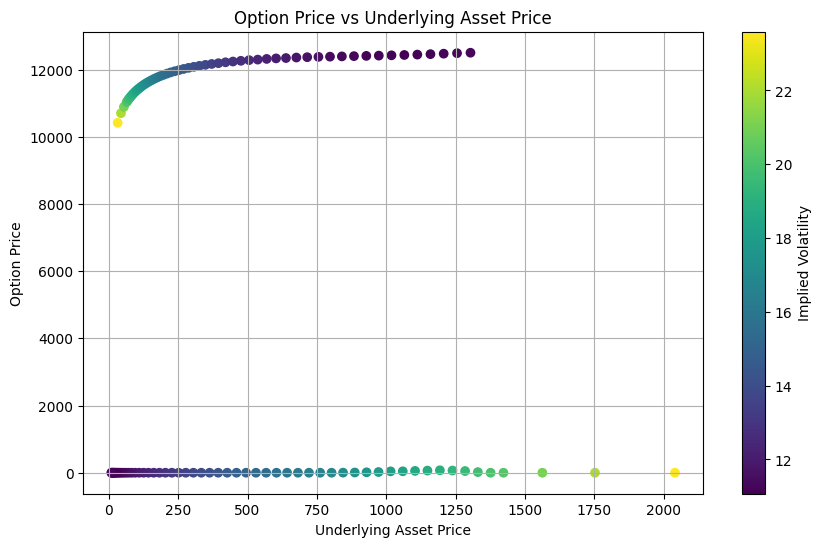

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['CF_CLOSE'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.colorbar(label='Implied Volatility')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Underlying Asset Price')
plt.grid(True)
plt.show()


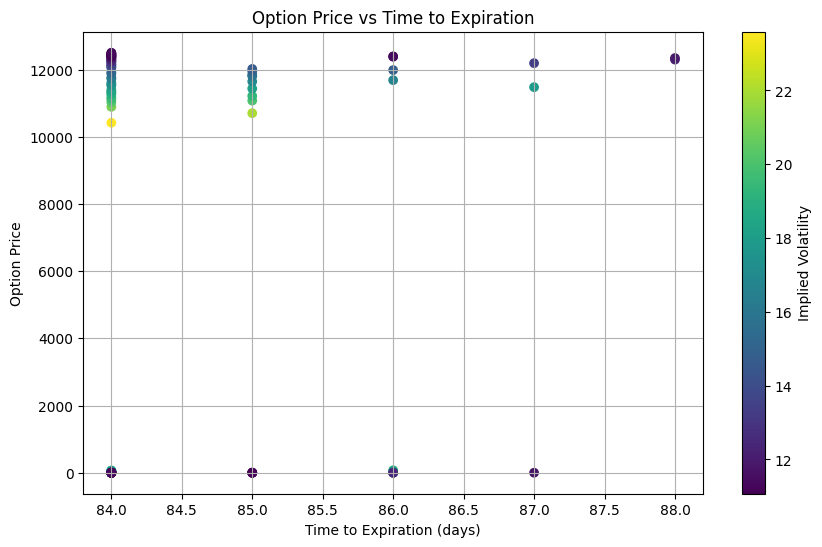

In [19]:
import matplotlib.pyplot as plt

# Calculate Time to Expiration in Days
df['TIME_TO_EXPIRATION'] = (pd.to_datetime(df['EXPIR_DATE']) - pd.to_datetime(df['CF_DATE'])).dt.days

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['TIME_TO_EXPIRATION'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.xlabel('Time to Expiration (days)')
plt.ylabel('Option Price')
plt.title('Option Price vs Time to Expiration')
plt.colorbar(scatter, label='Implied Volatility')
plt.grid(True)
plt.show()


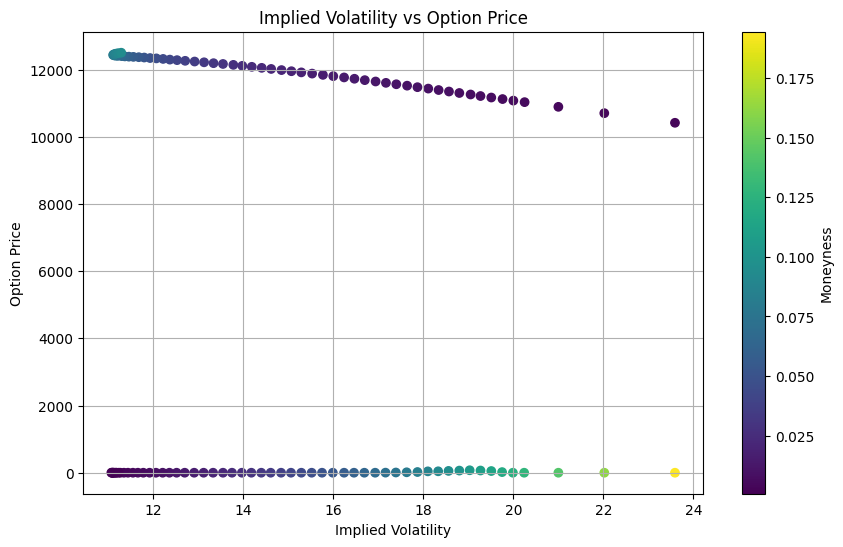

In [20]:
# scatter plot of implied volatility vs option price colored by moneyness

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['IMP_VOLT'], df['FOURIER_PRICE'], c = df['CF_CLOSE'] / df['STRIKE_PRC'], cmap='viridis')
plt.colorbar(label='Moneyness')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Price')
plt.title('Implied Volatility vs Option Price')
plt.grid(True)
plt.show()

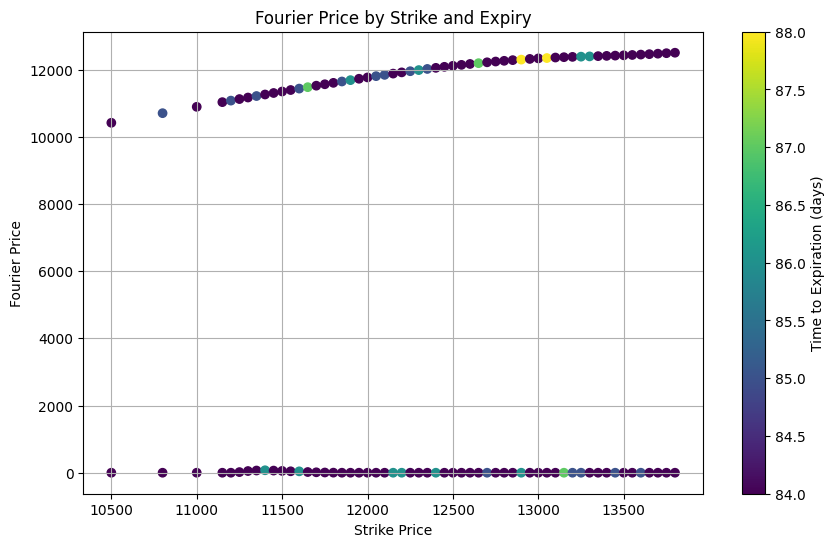

In [21]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c=df['TIME_TO_EXPIRATION'], cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Expiry')
plt.colorbar(scatter, label='Time to Expiration (days)')
plt.grid(True)
plt.show()

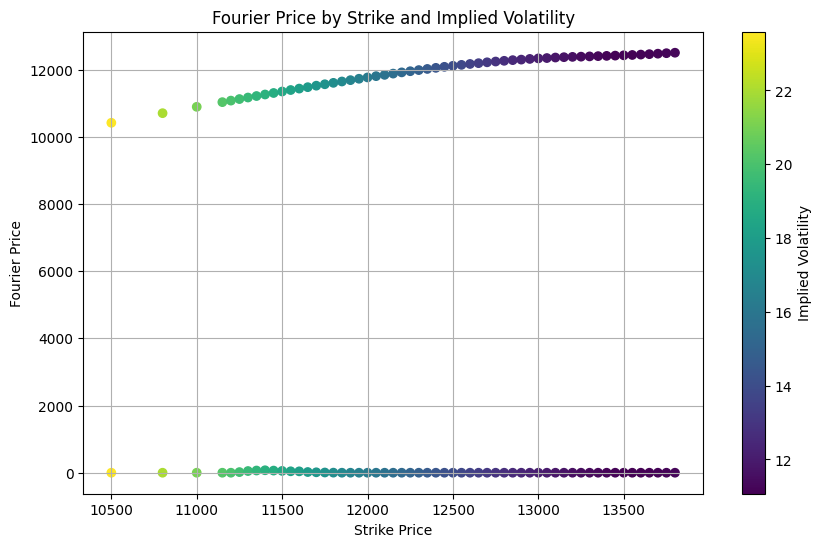

In [22]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c=df['IMP_VOLT'], cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Implied Volatility')
plt.colorbar(scatter, label='Implied Volatility')
plt.grid(True)
plt.show()

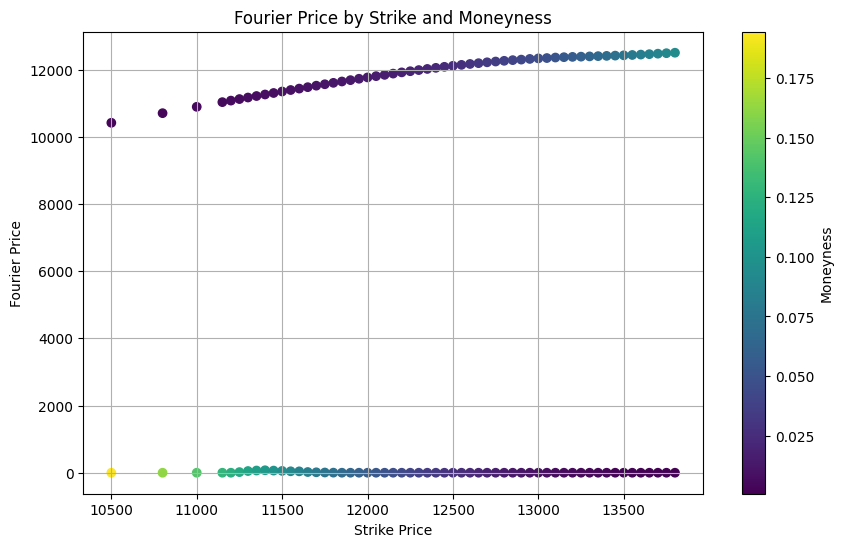

In [23]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['STRIKE_PRC'], df['FOURIER_PRICE'], c = df['CF_CLOSE'] / df['STRIKE_PRC']  # This is just one way to define moneyness
, cmap='viridis')
plt.xlabel('Strike Price')
plt.ylabel('Fourier Price')
plt.title('Fourier Price by Strike and Moneyness')
plt.colorbar(scatter, label='Moneyness')
plt.grid(True)
plt.show()


<ipython-input-24-3eaafb018ed6>:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  scatter.figure.colorbar(sm)


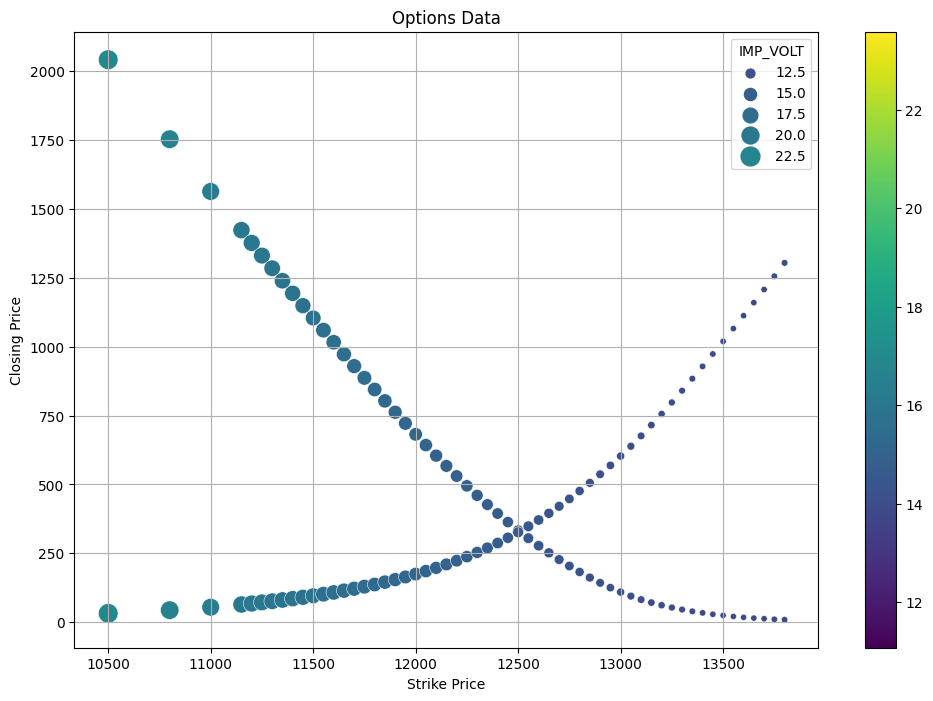

In [24]:
import seaborn as sns
# Filter out rows where PUTCALLIND is not null
options_data = df[~df['PUTCALLIND'].isnull()]

# Create scatterplot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=options_data, x='STRIKE_PRC', y='CF_CLOSE', hue='IMP_VOLT', size='IMP_VOLT', sizes=(20, 200), palette='viridis', hue_norm=(0, 50))

# Adding colorbar
norm = plt.Normalize(df['IMP_VOLT'].min(), df['IMP_VOLT'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
scatter.figure.colorbar(sm)

plt.xlabel('Strike Price')
plt.ylabel('Closing Price')
plt.title('Options Data')
plt.grid(True)
plt.show()